In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime 

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 2.8MB/s 


###Check GPU usage

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.9 GB  | Proc size: 160.3 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


###Create functions to load house data, extract sequences, and select appliance midpoints



In [0]:
# Import house_key.py file which serves as a lookup table for id, and appliance number
house_key = drive.CreateFile({'id':'1mlx9QROP7yD_P-Gt3kXx0oWksJImQQjW'})
house_key.GetContentFile('house_key.py')
import house_key

def import_house_data(selected_houses, appliance, house_info):
  '''Import raw house data from Drive. Resample to 1 minute intervals.
     Extract the aggregate and target appliance columns and place in
     a dataframe. Append each house to the end of the previous df.'''
  df = pd.DataFrame(columns = ['Aggregate', 'Appliance'])
  for house in selected_houses:
    id = house_info[house]['id']
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(f'house{house}.csv')
    house_df = pd.read_csv(f'house{house}.csv', parse_dates=['Time'], index_col='Time').drop(['Unix', 'Issues'], axis = 1).resample('min').mean()
    house_df = house_df[['Aggregate', house_info[house][appliance]]].dropna()
    house_df.rename(columns={house_info[house][appliance]:'Appliance'}, inplace=True)
    df = df.append(house_df, sort = False)
  return df  

"""
 Creates sequences that are time windows of the REFIT dataframe.
"""

def get_windows(df, n_steps):
  aggregate_load = np.array(df['Aggregate']) 
  appliance_load = np.array(df['Appliance'])
  seq_in = aggregate_load.reshape((len(aggregate_load), -1))
  seq_out = appliance_load.reshape((len(appliance_load), -1))
  combined_seq = np.hstack((seq_in, seq_out))

  X, y = list(), list()

  for i in range(0, len(combined_seq), n_steps):
    end_ix = i+ n_steps
    if end_ix > len(combined_seq):
        break
    seq_x, seq_y = combined_seq[i:end_ix, 0], combined_seq[i:end_ix, 1]
    X.append(seq_x)
    y.append(seq_y)
  return (X, y)


def import_without_appliance(selected_houses, house_info):
  '''Import raw house data from Drive. Resample to 1 minute intervals.
     Create a column of zeros to test whether a trained algorithm inaccurately
     predicts that an appliance is on.'''
  df = pd.DataFrame(columns = ['Aggregate', 'Appliance'])
  for house in selected_houses:
    id = house_info[house]['id']
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(f'house{house}.csv')
    house_df = pd.read_csv(f'house{house}.csv', parse_dates=['Time'], index_col='Time').drop(['Unix', 'Issues'], axis = 1).resample('min').mean()
    house_df = house_df[['Aggregate']].dropna()
    house_df['Appliance'] = np.zeros(len(house_df))
    df = df.append(house_df, sort = False)
  return df  


In [0]:
house_info = house_key.make_house_info()
print(house_info)

{1: {'id': '19B2f6SRrrqBaB58tH7wvzX6qBKwvAeBy', 'Dishwasher': 'Appliance6', 'Washing Machine': 'Appliance5', 'Tumble Dryer': 'Appliance4', 'Fridge': 'Appliance1', 'Electric Heater': 'Appliance9', 'Freezer': 'Appliance2'}, 2: {'id': '1QnnmIsepB6ThZgJQuYy_JjZ961-fdzwp', 'Dishwasher': 'Appliance3', 'Washing Machine': 'Appliance2', 'Fridge': 'Appliance1', 'Microwave': 'Appliance5', 'Kettle': 'Appliance8', 'Toaster': 'Appliance6'}, 3: {'id': '1EVouoLWiCINUgokLZ_g2J0xTmj77nwgt', 'Dishwasher': 'Appliance5', 'Washing Machine': 'Appliance6', 'Tumble Dryer': 'Appliance4', 'Fridge': 'Appliance2', 'Microwave': 'Appliance8', 'Kettle': 'Appliance9', 'Freezer': 'Appliance3', 'Toaster': 'Appliance1'}, 4: {'id': '1k2Yn70BEtLNgDErlZFNAP4fNvS5AjhC_', 'Washing Machine': 'Appliance4', 'Fridge': 'Appliance1', 'Microwave': 'Appliance8', 'Kettle': 'Appliance9', 'Freezer': 'Appliance2'}, 5: {'id': '1pnPIIyIM0Fgb2Kj0AAqSvAWJRsy9p8jH', 'Dishwasher': 'Appliance4', 'Washing Machine': 'Appliance3', 'Tumble Dryer': 

## *REQUIRES INPUT* Specify target appliance and training/test houses. Import data for selected houses


In [0]:
appliance = 'Kettle'     # must be a string with first letters capitalized
training_houses = [12, 13, 9]    # must be a list of integers
test_house = [4]              # must be a list of integers             


# Imports house data for target appliance and places in dataframes
df_train = import_house_data(training_houses, appliance, house_info)
df_test = import_house_data(test_house, appliance, house_info)
# df_test = import_without_appliance(test_house, house_info) #Use of testing for false positives when house doesn't have appliance

###Create training and test input sequences and target appliance midpoints

In [0]:
from sklearn.preprocessing import StandardScaler

n_steps = 248                # length of sequence window

# Training sequences
X_train, y_train = get_windows(df_train, n_steps = n_steps) 

# Test sequences
X_test, y_test = get_windows(df_test, n_steps = n_steps) 

# Create model input and target appliance arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


# Apply standardized scaling to output
scaley_train = y_train
# create scaler
scaler = StandardScaler()
# fit scaler on training dataset
scaler.fit(scaley_train)
# transform training dataset
scaley_train = scaler.transform(scaley_train)

#Now apply same scaling to y_test data
scaley_test = scaler.transform(y_test)


# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)

scaley_train = scaley_train.reshape((scaley_train.shape[0], scaley_train.shape[1], n_features))
scaley_test = scaley_test.reshape((scaley_test.shape[0], scaley_test.shape[1], n_features))


In [0]:
print(X_train.shape)
print(scaley_train.shape)
print(X_test.shape)
print(scaley_test.shape)

(7653, 248, 1)
(7653, 248, 1)
(3177, 248, 1)
(3177, 248, 1)


###Build AE model

In [0]:
# Build model and compile
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D 
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential()

model.add(Conv1D(16, kernel_size=6, strides =1, activation='relu', input_shape=(X_train.shape[1], 1), padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(8, kernel_size=4, strides = 1, activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(AveragePooling1D(pool_size =2, strides =2))

model.add(Dense(n_steps*8, activation = 'relu'))
model.add(BatchNormalization())
model.add(AveragePooling1D(pool_size =2, strides =2))

model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(UpSampling1D(size =2))

model.add(Dense(n_steps*8, activation = 'relu'))
model.add(BatchNormalization())
model.add(UpSampling1D(size =2))

model.add(Conv1D(8, kernel_size=4, strides = 1, activation='relu', padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(16, kernel_size=4, strides = 1, activation='sigmoid', padding = 'same'))
model.add(BatchNormalization())

model.add(Dense(1, activation = 'relu'))
model.add(BatchNormalization())


adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=0.00000008, decay=0.0, amsgrad=False)

model.compile(loss='mse', optimizer=adam, metrics=['mae'])

print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 248, 16)           112       
_________________________________________________________________
batch_normalization_25 (Batc (None, 248, 16)           64        
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 248, 8)            520       
_________________________________________________________________
batch_normalization_26 (Batc (None, 248, 8)            32        
_________________________________________________________________
average_pooling1d_7 (Average (None, 124, 8)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 124, 1984)         17856     
_________________________________________________________________
batch_normalization_27 (Batc (None, 124, 1984)         7936      
__________

## ***REQUIRES INPUT*** Define number of epochs and batch size.  Fit model

In [0]:
batch_size = 600
epochs = 10

early_stop = EarlyStopping(monitor='mean_absolute_error', min_delta=0.2, patience=3, verbose=0, mode='auto', baseline=None)
#checkpointer = ModelCheckpoint(filepath='/content/weights.hdf5')
history = model.fit(X_train, scaley_train, batch_size = batch_size, epochs = epochs, verbose=1) #, callbacks=[early_stop])

#model.save('conv_dnn.h5')

Epoch 1/10
7653/7653 [==============================] - 18s 2ms/step - loss: 1.1782 - mean_absolute_error: 0.5870
Epoch 2/10
7653/7653 [==============================] - 12s 2ms/step - loss: 0.6697 - mean_absolute_error: 0.3153
Epoch 3/10
7653/7653 [==============================] - 12s 2ms/step - loss: 0.5077 - mean_absolute_error: 0.2413
Epoch 4/10
7653/7653 [==============================] - 12s 2ms/step - loss: 0.4389 - mean_absolute_error: 0.1958
Epoch 5/10
7653/7653 [==============================] - 12s 2ms/step - loss: 0.3983 - mean_absolute_error: 0.1699
Epoch 6/10
7653/7653 [==============================] - 12s 2ms/step - loss: 0.3731 - mean_absolute_error: 0.1486
Epoch 7/10
7653/7653 [==============================] - 12s 2ms/step - loss: 0.3566 - mean_absolute_error: 0.1463
Epoch 8/10
7653/7653 [==============================] - 12s 2ms/step - loss: 0.3468 - mean_absolute_error: 0.1412
Epoch 9/10
7653/7653 [==============================] - 12s 2ms/step - loss: 0.3363 - me

###Plot model loss (MSE)

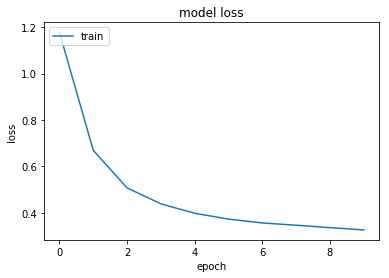

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [0]:
# Copy into excel to compare loss curve over multiple runs
history.history['loss']

[1.1781554863715535,
 0.6696521368787505,
 0.507715697302065,
 0.43886860627980384,
 0.39830201310487134,
 0.37310674077433637,
 0.3565801838153673,
 0.34677407661871273,
 0.33628515594849534,
 0.3265185508948595]

###Predict appliance load for test (and training) set

Typically don't do this for the training set because of the size of data. We are only really interested in the test set. 

In [0]:
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

###Evaluate test set

In [0]:
results = model.evaluate(X_test, scaley_test)
print(results)

3177/3177 [==============================] - 3s 1ms/step
[0.236507406503403, 0.18468837010380154]


###Unscale the target and prediction data for comparison to aggregate

In [0]:
#Reshape the appliance data and predictions
y_hat_train = y_hat_train.reshape(y_hat_train.shape[0], y_hat_train.shape[1])
y_hat_test = y_hat_test.reshape(y_hat_test.shape[0], y_hat_test.shape[1])
scaley_test = scaley_test.reshape(scaley_test.shape[0], scaley_test.shape[1])
scaley_train = scaley_train.reshape(scaley_train.shape[0], scaley_train.shape[1])

#Unscale the target and prediction data
u_y_hat_train = scaler.inverse_transform(y_hat_train)
u_y_hat_test = scaler.inverse_transform(y_hat_test) 
u_y_test = scaler.inverse_transform(scaley_test) 
u_y_train = scaler.inverse_transform(scaley_train) 

#Stack the window sequences for comparisons
u_y_hat_train = np.hstack(u_y_hat_train[:,:])
u_y_hat_test = np.hstack(u_y_hat_test[:,:])
u_y_test = np.hstack(u_y_test[:,:])
u_y_train = np.hstack(u_y_train[:,:])

#Reshape the aggregate 
X_test = X_test.reshape(X_test.shape[0]*X_test.shape[1])


In [0]:
print(y_hat_train.shape)
print(y_hat_test.shape)
print(y_test.shape)
print(y_train.shape)
print(u_y_hat_train.shape)
print(u_y_hat_test.shape)
print(u_y_test.shape)
print(u_y_train.shape)
print(X_test.shape)
print(df_test.shape)

(7653, 248)
(3177, 248)
(3177, 248)
(7653, 248)
(1897944,)
(787896,)
(787896,)
(1897944,)
(787896,)
(787972, 2)


### Prep model outputs for plotting and export as CSV

In [0]:
#y_hat_out = y_hat.reshape(y_hat.shape[0])
#y_hat_test_out = u_y_hat_test.reshape(u_y_hat_test.shape[0]*u_y_hat_test.shape[1])

#y_train_out = y_train.reshape(y_train.shape[0])
#y_test_out = u_y_test.reshape(u_y_test.shape[0]*u_y_test.shape[1])

#train_results = pd.DataFrame({'y_train':y_train_out, 'y_hat_train': y_hat_train_out})
test_results = pd.DataFrame({'y_test': u_y_test, 'y_test_hat': u_y_hat_test})

#train_csv = train_results.to_csv('train_results.csv', index = None, header=True)
test_csv = test_results.to_csv('test_results.csv', index = None, header=True)

   y_test  y_test_hat
0     0.0  -36.107494
1     0.0  -35.650970
2     0.0  -35.071468
3     0.0  -36.283703
4     0.0  -35.500324


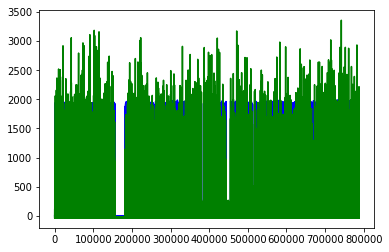

In [0]:
print(test_results.head())
plt.plot(test_results.y_test, 'b', test_results.y_test_hat, 'g')


###Calculate Mean Absolute Error (MAE) and Signal Aggregate Error (SAE)


In [0]:
def get_mae(df):
    df['abs_err']= np.abs(df.y_test-df.y_test_hat)
    mae = np.round(df.abs_err.sum()/len(df),2)
    print(f'Mean absolute error: {mae}')
    return mae

def get_sae(df):
    r = df.y_test.sum()
    r_hat = df.y_test_hat.sum()
    sae = np.round(np.abs(r_hat-r)/r, 4)
    print(f'Signal Aggregate Error: {sae}')
    return sae

def get_epd(df_test, u_y_hat_test):
    app_test_df = df_test.Appliance[0:len(u_y_hat_test)]
    df_out =  pd.DataFrame({'Test':app_test_df,'Predicted':u_y_hat_test,}, index=app_test_df.index)
    df_out = df_out.resample('D').sum()/60
    df_out['EPD'] = np.abs(df_out.Test-df_out.Predicted)
    epd = np.round(df_out.EPD.mean(), 2)
    print(f'Average Energy Per Day Error (EPD): {epd}')
    return epd
  
  
mae = get_mae(test_results)
sae = get_sae(test_results)
epd = get_epd(df_test, u_y_hat_test)


Mean absolute error: 42.76
Signal Aggregate Error: 3.0561
Average Energy Per Day Error (EPD): 678.3


###Plot Training Data and Model Fit

In [0]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.themes import built_in_themes
from bokeh.io import curdoc

output_notebook()
curdoc().theme = 'light_minimal'

p = figure(plot_width=1200, plot_height=600, x_axis_type="datetime", title = 'Training Data and Model Fit')
p.xaxis.axis_label = "Time"
p.yaxis.axis_label = "Watts"

x0 = np.array(df_train.index[0:60000])         #  [0:len(u_y_train)])
y0 = np.array(df_train.Aggregate[0:60000])     #  [0:len(u_y_train)])
y1 = u_y_train[0:60000]
y2 = u_y_hat_train[0:60000]


#p.line(x0, y0, legend= "Aggregate", line_color='red')
p.line(x0, y1, legend= "Actual", line_color='blue')
p.line(x0, y2, legend= "Predicted", line_color='green')


show(p)


Output hidden; open in https://colab.research.google.com to view.

###Plot Test Data and Model Predictions

In [0]:
output_notebook()
curdoc().theme = 'light_minimal'

p = figure(plot_width=1200, plot_height=600, x_axis_type="datetime", title = 'Test Data and Model Predictions')
p.xaxis.axis_label = "Time"
p.yaxis.axis_label = "Watts"

x0 = np.array(df_test.index[0:60000])
y0 = np.array(df_test.Aggregate[0:60000]) 
y1 = u_y_test[0:60000]
y2 = u_y_hat_test[0:60000]


p.line(x0, y0, legend= "Aggregate", line_color='red')
p.line(x0, y1, legend= "Actual", line_color='blue')
p.line(x0, y2, legend= "Predicted", line_color='green')

show(p)

Output hidden; open in https://colab.research.google.com to view.